# Nhóm 4 - Dự đoán giá nhà
- Lý Thanh Hải - 102190061
- Lê Thị Bình - 102190053
- Phạm Sỹ Hoàng - 102190065

# 1. mô tả các thống kê tổng quan về tập dữ liệu (số mẫu, số đặc trưng của 1 mẫu, kiểu dữ liệu của mỗi đặc trưng, số mẫu dữ liệu trống của mỗi đặc trưng,...)

In [1]:
# import thu vien

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import style
from matplotlib.gridspec import GridSpec
import seaborn as sns
from scipy import stats
from sklearn.linear_model import Ridge
from sklearn. impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import make_column_selector,make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score, train_test_split
import sklearn.metrics as metrics
from sklearn.metrics import mean_squared_log_error 
from sklearn.metrics import accuracy_score, r2_score

### Sau khi quét dữ liệu thô từ các nguồn dữ liệu uy tín, chúng ta sẽ phân tích độ chuẩn của dữ liệu qua các phương pháp phân tích

1. Ta sẽ đọc file csv từ local

In [2]:
data = pd.read_csv("rawData.csv")
data.drop(columns=['Unnamed: 0'], inplace=True)


2. Ta sẽ kiểm tra các cột đặc trực để xem dữ liệu có thể triết xuất được những thông tin gì phù hợp để đánh giá nhà đất
* Ở đây như ta thấy, tiêu đề và id_estate đóng vai trò định danh cho bất động sản nên sẽ không giúp đánh giá được độ chênh lệch giá của dữ liệu
* Các trường dữ liệu còn lại rất phù hợp đặc trưng nhà đất, đặc biệt là trường address sẽ ảnh hưởng đến price của từng area vì vị trí của bất động sản cũng ảnh hưởng ít nhiều đến độ tăng giá chung của thị trường

In [3]:
data.columns

Index(['title', 'address', 'area', 'price', 'number_bedroom', 'number_wc',
       'number_floor', 'direction', 'entrance', 'facade', 'number_parking',
       'id_estate'],
      dtype='object')

3. Vì dữ liệu quét về khá lớn, ta sẽ trích xuất một số lượng mẫu nhỏ ở đầu dữ liệu để đánh giá xem các dữ liệu có theo cùng một chuẩn hay có dự liệu xấu nào cần được làm sạch.

In [4]:

data.head()

,title,address,area,price,number_bedroom,number_wc,number_floor,direction,entrance,facade,number_parking,id_estate
0,Căn hộ nghỉ dưỡng ngay trung tâm hà nội chỉ 1 ...,"Vinhomes Smart City, Phường Trung Văn, Quận Na...",30.0,1.25,1.0,1.0,27.0,Đông bắc,30.0,30.0,3.0,3947348
1,Căn 2 pn full nội thất view hồ 10ha. công viên...,"Vinhomes Smart City, Phường Cầu Diễn, Quận Nam...",55.0,2.10,2.0,1.0,20.0,Đông bắc,50.0,5.0,3.0,3947371
2,"Duy nhất căn 2 ngủ tầng đẹp giá 1 tỷ 779triệu,...","Tecco Diamond, Xã Tứ Hiệp, Huyện Thanh Trì, Hà...",65.0,1.70,2.0,2.0,NaN,NaN,NaN,NaN,1.0,3946737
3,Nhận nhà ở ngay không lo trả lãi tại teccodiam...,"Tecco Diamond, Thị Trấn Văn Điển, Huyện Thanh ...",69.0,1.93,2.0,2.0,NaN,NaN,NaN,NaN,1.0,3946177
4,Chính chủ bán căn hộ chung cư citadines centra...,"Citadines Bình Dương, Phường An Thạnh, Thị Xã ...",114.0,3.05,3.0,2.0,16.0,NaN,50.0,NaN,NaN,3944714


* Ta thấy rằng cột number_floor có một số dòng không có dữ liệu, mặc dù tiêu đề title có đề cập đến số tầng, chứng tỏ dữ liệu đã bị quét thiếu dẫn tới dòng này không đáng tin cạy để thu75ch iện training model.
Vì lí do trên, ngoài cột number_floor, ta sẽ thể hiện xem các cột còn lại dữ liệu null nhiều không để đi đến quyết định có bỏ chúng ra khỏi dữ liệu hay chấp nhận dùng để huấn luyện model.

In [5]:
data.isnull().sum()



title                0
address              0
area                 0
price                0
number_bedroom     328
number_wc          370
number_floor      1347
direction         1378
entrance          1805
facade            2001
number_parking    1476
id_estate            0
dtype: int64

* Sau khi sử dụng isnull cùng hàm sum, ta thấy các cột null chỉ ảnh hưởng đến sự tiện ích của căn nhà nhưng các trường quan trọng như address, area và price thì đều đầy đủ thông tin nên vẫn có thể cân nhắc để sử dụng trong huấn luyện.

4. Vì trường price có một số dữ liệu là thỏa thuân (không null nhưng không phải dạng số) nên ta cần normalize về số như các dòng khác để tiến hành mô tả dữ liệu huấn luyện

In [6]:

data.describe()

,area,price,number_bedroom,number_wc,number_floor,entrance,facade,number_parking,id_estate
count,2518.000000,2518.000000,2190.000000,2148.000000,1171.000000,713.000000,517.000000,1042.000000,2.518000e+03
mean,65.948034,1.977205,1.976712,1.660615,21.616225,38.867461,213.689942,2.270633,3.903203e+06
std,28.201568,1.376620,0.811580,0.654456,59.255214,75.786543,3224.771597,1.356551,1.072902e+05
min,0.000000,0.029000,1.000000,1.000000,1.000000,1.000000,3.000000,1.000000,2.623702e+06
25%,48.000000,1.000000,1.000000,1.000000,10.000000,20.000000,12.000000,1.000000,3.920224e+06
50%,63.000000,1.790000,2.000000,2.000000,20.000000,30.000000,30.000000,2.000000,3.939052e+06
75%,76.000000,2.500000,2.000000,2.000000,29.000000,35.000000,50.000000,4.000000,3.942830e+06
max,349.000000,10.000000,11.000000,11.000000,2012.000000,743.000000,73000.000000,4.000000,3.950141e+06


* Trong mô tả ở trên, ta thấy số lượng dữ liệu được chia khá đồng đều, mặc dù cột facde là thấp nhất nhưng do đa số các bất động sản đều là căn hộ chung cư cao cấp nên việc không có mặt tiền là điều dễ hiệu và đặc biệt, đối với một nửa số nhà mặt tiền thì họ không có bãi đỗ xe nên số lượng number_parking bằng nửa số dữ liệu là hợp lý.

# 2. xuất ra các thống kê mô tả trực quan về các đặc trưng (ví dụ: dùng boxplot, histogram, scatter plot về độ tương quan,…).


- Do tuong quan giua cac dac trung

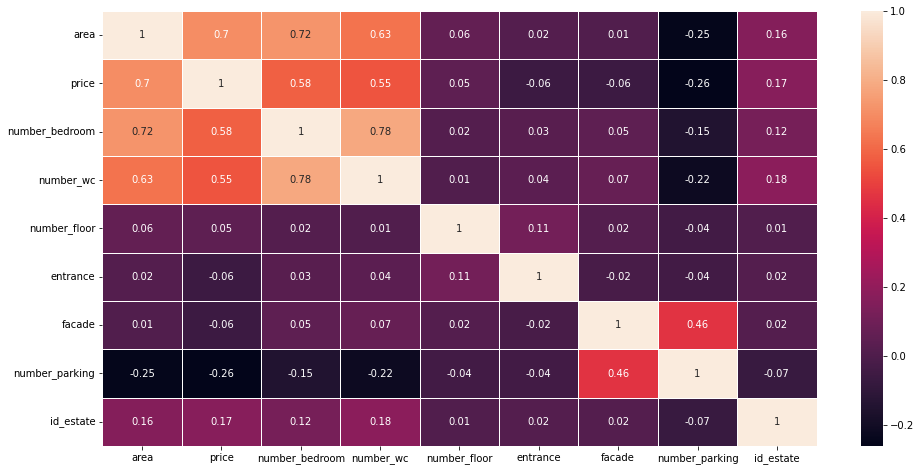

In [7]:
corr = data.corr().round(2)
mask = np.zeros_like(corr)
plt.subplots(figsize=(16, 8))
ax = sns.heatmap(corr, annot=True, linewidths=.5)

- phan bo cua dac trung

<AxesSubplot:xlabel='id_estate', ylabel='Count'>

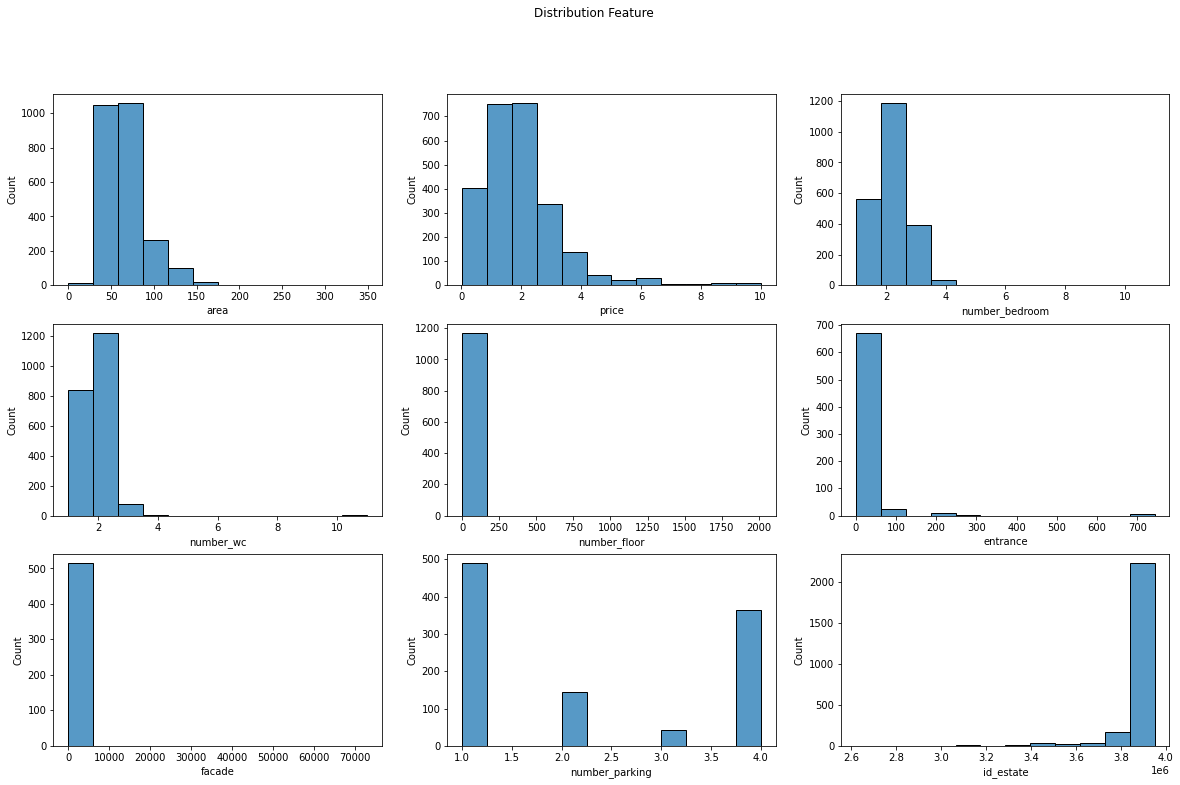

In [8]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))

fig.suptitle('Distribution Feature')

sns.histplot(data= data["area"], bins= 12, kde= False, ax= axes[0, 0])
sns.histplot(data= data["price"], bins= 12, kde= False, ax= axes[0, 1])
sns.histplot(data= data["number_bedroom"], bins= 12, kde= False, ax= axes[0, 2])
sns.histplot(data= data["number_wc"], bins= 12, kde= False, ax= axes[1, 0])
sns.histplot(data= data["number_floor"], bins= 12, kde= False, ax= axes[1, 1])
sns.histplot(data= data["entrance"], bins= 12, kde= False, ax= axes[1, 2])
sns.histplot(data= data["facade"], bins= 12, kde= False, ax= axes[2, 0])
sns.histplot(data= data["number_parking"], bins= 12, kde= False, ax= axes[2, 1])
sns.histplot(data= data["id_estate"], bins= 12, kde= False, ax= axes[2, 2])


- quan he giua gia ca voi cac dac trung

<AxesSubplot:xlabel='price', ylabel='id_estate'>

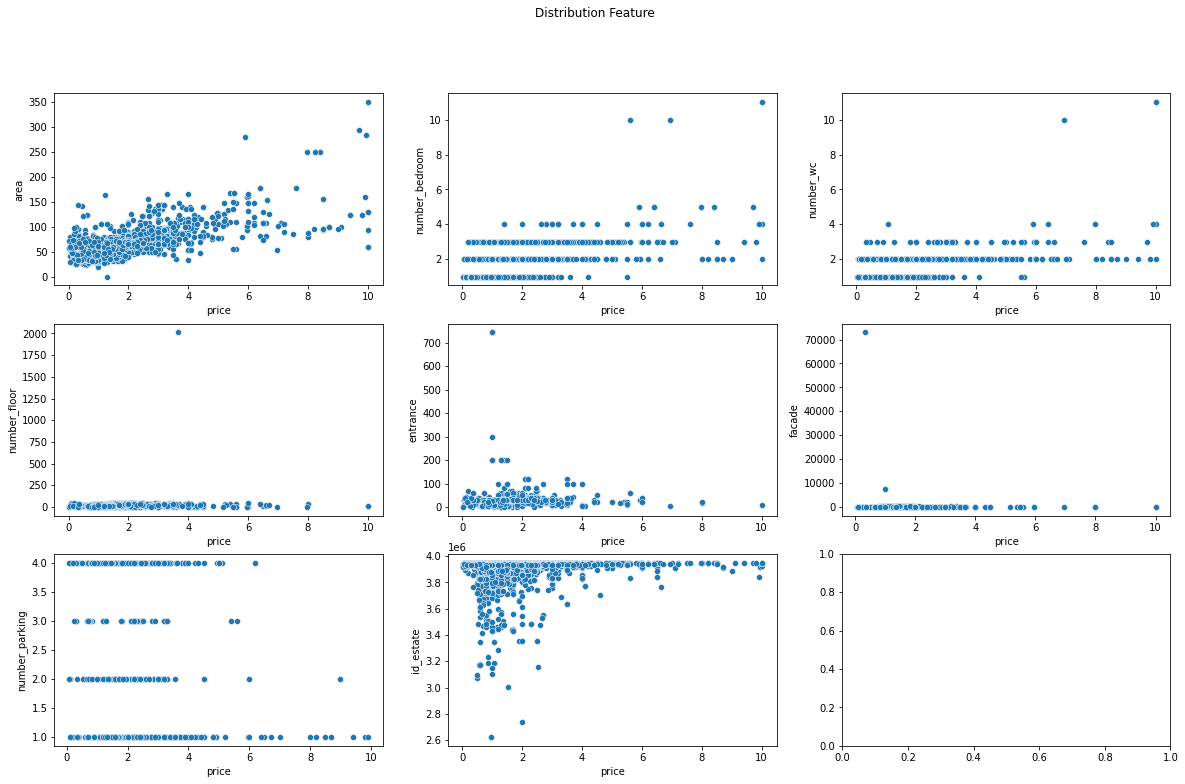

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(20, 12))

fig.suptitle('Distribution Feature')

sns.scatterplot(data=data, x="price", y="area", ax= axes[0, 0])
sns.scatterplot(data=data, x="price", y="number_bedroom", ax= axes[0, 1])
sns.scatterplot(data=data, x="price", y="number_wc", ax= axes[0, 2])
sns.scatterplot(data=data, x="price", y="number_floor", ax= axes[1, 0])
sns.scatterplot(data=data, x="price", y="entrance", ax= axes[1, 1])
sns.scatterplot(data=data, x="price", y="facade", ax= axes[1, 2])
sns.scatterplot(data=data, x="price", y="number_parking", ax= axes[2, 0])
sns.scatterplot(data=data, x="price", y="id_estate", ax= axes[2, 1])

Phân bố của các đặc trưng cho ta thấy:
*Các phân bố chủ yếu là phân bố lệch chuẩn.

In [10]:
from typing import Tuple
from sklearn.base import BaseEstimator, TransformerMixin


def find_boxplot_boundaries(
    col: pd.Series, whisker_coeff: float = 1.5
) -> Tuple[float, float]:
    """Findx minimum and maximum in boxplot.

    Args:
        col: a pandas serires of input.
        whisker_coeff: whisker coefficient in box plot
    """
    Q1 = col.quantile(0.25)
    Q3 = col.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - whisker_coeff * IQR
    upper = Q3 + whisker_coeff * IQR
    return lower, upper


class BoxplotOutlierClipper(BaseEstimator, TransformerMixin):
    def __init__(self, whisker_coeff: float = 1.5):
        self.whisker = whisker_coeff
        self.lower = None
        self.upper = None

    def fit(self, X: pd.Series):
        self.lower, self.upper = find_boxplot_boundaries(X, self.whisker)
        return self

    def transform(self, X):
        return X.clip(self.lower, self.upper)

<AxesSubplot:>

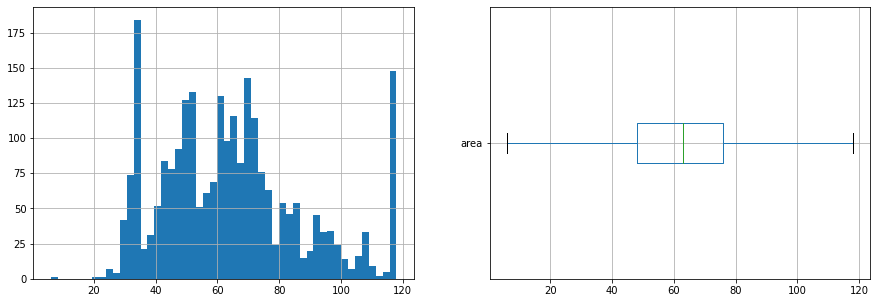

In [11]:


data["area"] = BoxplotOutlierClipper().fit_transform(data["area"])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
data["area"].hist(bins=50, ax=axes[0])
data["area"].to_frame().boxplot(ax=axes[1], vert=False)


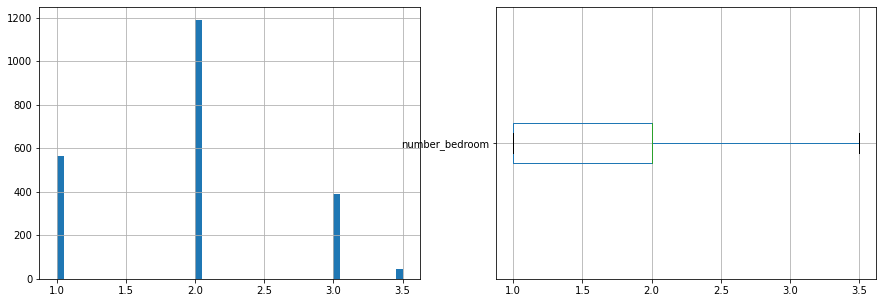

In [12]:
data["number_bedroom"] = BoxplotOutlierClipper().fit_transform(data["number_bedroom"])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
data["number_bedroom"].hist(bins=50, ax=axes[0])
data["number_bedroom"].to_frame().boxplot(ax=axes[1], vert=False);

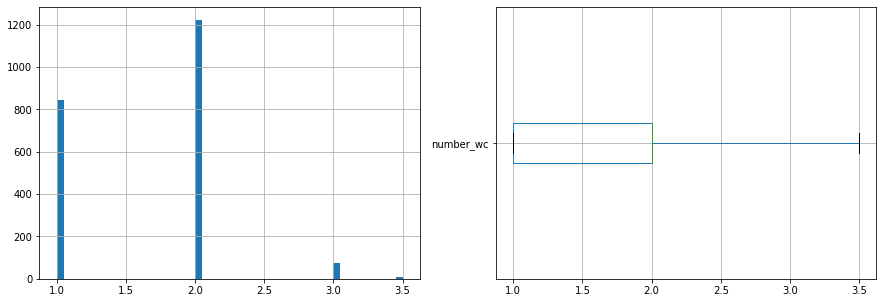

In [13]:
data["number_wc"] = BoxplotOutlierClipper().fit_transform(data["number_wc"])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
data["number_wc"].hist(bins=50, ax=axes[0])
data["number_wc"].to_frame().boxplot(ax=axes[1], vert=False);

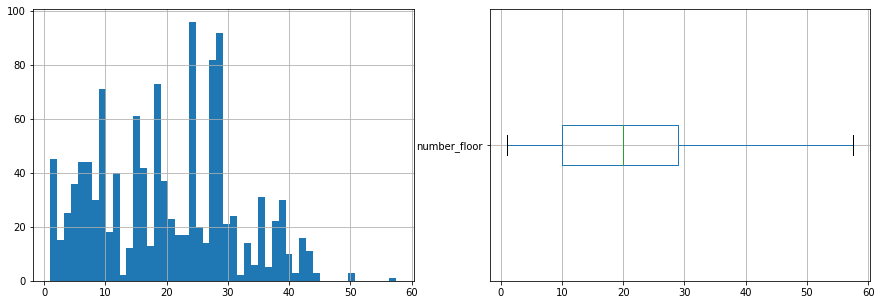

In [14]:
data["number_floor"] = BoxplotOutlierClipper().fit_transform(data["number_floor"])

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
data["number_floor"].hist(bins=50, ax=axes[0])
data["number_floor"].to_frame().boxplot(ax=axes[1], vert=False);

In [15]:
# data["address"] = address_stat = data["address"].apply(lambda x: x.split(",")[len(x.split(",")) - 1])
data["address"] = data["address"].apply(lambda x: x.split(",")[len(x.split(",")) - 1])

address_stats = data.groupby('address')["address"].agg('count').sort_values(ascending= False)
address_stats

address
 Hà Nội                       1154
 Bình Dương                    526
 TP HCM                        321
 Bình Định                     145
 Đồng Nai                       53
 Đà Nẵng                        38
                                35
 Khánh Hòa                      34
 Bắc Ninh                       25
 Quảng Ninh                     24
 Hưng Yên                       20
 Bà Rịa - Vũng Tàu              19
                                17
 Hải Phòng                      16
 Bắc Giang                      16
 Thanh Hóa                      12
 Quảng Bình                     10
 Vĩnh Phúc                       8
 Nghệ An                         7
 Ha Noi                          5
 Phú Thọ                         5
 Vĩnh Phúc                       4
 B\u00ECnh D\u01B0\u01A1ng       3
 Vĩnh Long                       3
 B\u00ECnh \u0110\u1ECBnh        3
 Thái Nguyên                     2
 Long An                         2
 Tây Ninh                        2
 Đắk Lắk    

In [16]:

data['number_bedroom'] = data['number_bedroom'].replace(np.nan, np.nanmedian(data['number_bedroom']))
data['number_wc'] = data['number_wc'].replace(np.nan, np.nanmedian(data['number_wc']))
data['number_floor'] = data['number_floor'].replace(np.nan, np.nanmedian(data['number_floor']))
data['entrance'] = data['entrance'].replace(np.nan, np.nanmedian(data['entrance']))
data['facade'] = data['facade'].replace(np.nan, np.nanmedian(data['facade']))
data['number_parking'] = data['number_parking'].replace(np.nan, np.nanmedian(data['number_parking']))
data.isna().sum()
data.to_csv("cleanData.csv")
# print(np.nanmedian(data1['number_parking']))

In [17]:
data.head()

,title,address,area,price,number_bedroom,number_wc,number_floor,direction,entrance,facade,number_parking,id_estate
0,Căn hộ nghỉ dưỡng ngay trung tâm hà nội chỉ 1 ...,Hà Nội,30.0,1.25,1.0,1.0,27.0,Đông bắc,30.0,30.0,3.0,3947348
1,Căn 2 pn full nội thất view hồ 10ha. công viên...,Hà Nội,55.0,2.10,2.0,1.0,20.0,Đông bắc,50.0,5.0,3.0,3947371
2,"Duy nhất căn 2 ngủ tầng đẹp giá 1 tỷ 779triệu,...",Hà Nội,65.0,1.70,2.0,2.0,20.0,NaN,30.0,30.0,1.0,3946737
3,Nhận nhà ở ngay không lo trả lãi tại teccodiam...,Hà Nội,69.0,1.93,2.0,2.0,20.0,NaN,30.0,30.0,1.0,3946177
4,Chính chủ bán căn hộ chung cư citadines centra...,Bình Dương,114.0,3.05,3.0,2.0,16.0,NaN,50.0,30.0,2.0,3944714


In [18]:
from sklearn.preprocessing import LabelEncoder

gle = LabelEncoder()
genre_labels = gle.fit_transform(data['address'])
genre_mappings = {index: label for index, label in 
                  enumerate(gle.classes_)}
# genre_mappings
data


,title,address,area,price,number_bedroom,number_wc,number_floor,direction,entrance,facade,number_parking,id_estate
0,Căn hộ nghỉ dưỡng ngay trung tâm hà nội chỉ 1 ...,Hà Nội,30.0,1.250,1.0,1.0,27.0,Đông bắc,30.0,30.0,3.0,3947348
1,Căn 2 pn full nội thất view hồ 10ha. công viên...,Hà Nội,55.0,2.100,2.0,1.0,20.0,Đông bắc,50.0,5.0,3.0,3947371
2,"Duy nhất căn 2 ngủ tầng đẹp giá 1 tỷ 779triệu,...",Hà Nội,65.0,1.700,2.0,2.0,20.0,NaN,30.0,30.0,1.0,3946737
3,Nhận nhà ở ngay không lo trả lãi tại teccodiam...,Hà Nội,69.0,1.930,2.0,2.0,20.0,NaN,30.0,30.0,1.0,3946177
4,Chính chủ bán căn hộ chung cư citadines centra...,Bình Dương,114.0,3.050,3.0,2.0,16.0,NaN,50.0,30.0,2.0,3944714
...,...,...,...,...,...,...,...,...,...,...,...,...
2513,"Mở bán căn hộ tttp.thuận an, giá 896 triêu/căn...",Bình Dương,42.0,0.896,1.0,1.0,20.0,NaN,30.0,30.0,2.0,3931551
2514,"48m2 bàn giao 1pn có thể tự ngăn thành 2pn, ch...",Bình Dương,48.0,1.200,1.0,1.0,10.0,NaN,30.0,30.0,2.0,3931239
2515,Sắp mở bán dự án căn hộ thuận an - giá gốc đầu...,Bình Dương,33.0,0.800,1.0,1.0,20.0,NaN,30.0,30.0,2.0,3932155
2516,Căn hộ độc tôn ngay tp.thuận an cạnh aeon mall...,Bình Dương,32.0,0.800,1.0,1.0,20.0,NaN,30.0,30.0,2.0,3918708


In [19]:
X=data[["area", "number_bedroom", "number_wc",  "address","number_floor"]]
y = data["price"].astype(float)


* Tạo Pipeline 

In [20]:
imp_median = SimpleImputer(strategy='median', add_indicator=True)
scaler = StandardScaler()
imp_constant = SimpleImputer(strategy='constant')
ohe = OneHotEncoder(handle_unknown='ignore')
num_cols = make_column_selector(dtype_include='number')
cat_cols = make_column_selector(dtype_exclude='number')
preprocessor = make_column_transformer(
    (make_pipeline(imp_median, scaler), num_cols),
    (make_pipeline(imp_constant, ohe), cat_cols)
)

* Dùng Grid_search tìm kiếm các siêu tham số

In [21]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.base import BaseEstimator
from sklearn.preprocessing import StandardScaler
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
 
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1)
def parameter_model_Random(X_train, y_train):
    pipe = make_pipeline(preprocessor, RandomForestRegressor())
   

    parameter = {
            'randomforestregressor__n_estimators': [0,50, 100],
            'randomforestregressor__criterion': ('squared_error', 'absolute_error', 'poisson'),
            'randomforestregressor__max_depth': [None,5,10],

    }

    model = GridSearchCV(pipe, param_grid=parameter, cv=5, n_jobs=-1, verbose=1)
    model.fit(X_train, y_train)
    print(f"model best params: {model.best_params_}")
    


def parameter_model_XGB(X_train, y_train):
    pipe = make_pipeline(preprocessor, XGBRegressor())
   

    parameter = {
            'xgbregressor__eta': [0.3, 0.1, 0.01],
            'xgbregressor__max_depth': [None,1,10],
            'xgbregressor__n_estimators': [0,50, 100]

    }

    model = GridSearchCV(pipe, param_grid=parameter, cv=5, n_jobs=-1, verbose=1)
    model.fit(X_train, y_train)
    print(f"model best params: {model.best_params_}")
      


In [22]:
parameter_model_Random(X_train, y_train)
parameter_model_XGB(X_train, y_train)

Fitting 5 folds for each of 27 candidates, totalling 135 fits


/home/binbin/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:372: FitFailedWarning: 
45 fits failed out of a total of 135.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
45 fits failed with the following error:
Traceback (most recent call last):
  File "/home/binbin/.local/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 680, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/binbin/.local/lib/python3.8/site-packages/sklearn/pipeline.py", line 394, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/binbin/.local/lib/python3.8/site-packages/sklearn/ensemble/_forest.py", line 392, in fit
    self._validate_estimator()
  File "/

model best params: {'randomforestregressor__criterion': 'squared_error', 'randomforestregressor__max_depth': 10, 'randomforestregressor__n_estimators': 100}
Fitting 5 folds for each of 27 candidates, totalling 135 fits
model best params: {'xgbregressor__eta': 0.1, 'xgbregressor__max_depth': None, 'xgbregressor__n_estimators': 50}


* Fit model và đánh giá model bằng tập Val với tham số mặc định

In [23]:
def fit_model_val_Random_n(X_train, y_train,X_val):   
    pipe = make_pipeline(preprocessor, RandomForestRegressor())
    pipe.fit(X_train, y_train)
    predict = pipe.predict(X_val)
    # print(f'MSE             : {metrics.mean_squared_error(y_val, predict)}\n'
    #         f'\nRMSE            : '
    #         f'{np.sqrt(metrics.mean_squared_error(y_val, predict))}\n'
    #         f'MAE             : {metrics.mean_absolute_error(y_val, predict)}\n'
    #         #f'Mean abs % error: '
    #         #f'{metrics.mean_absolute_percentage_error(y_test, predict)}\n'
    #         f'\n'
        
    #         f'Score (val)    : {pipe.score(X_val, y_val)}\n')
    return (np.sqrt(metrics.mean_squared_error(y_val, predict)),metrics.mean_absolute_percentage_error(y_val, predict),r2_score(y_val, predict))
    
def fit_model_val_XGB_n(X_train, y_train,X_val):   
    pipe = make_pipeline(preprocessor, XGBRegressor())
    pipe.fit(X_train, y_train)
    predict = pipe.predict(X_val)
    
    return (np.sqrt(metrics.mean_squared_error(y_val, predict)),metrics.mean_absolute_percentage_error(y_val, predict),r2_score(y_val, predict))
    

* Fit model và đánh giá model bằng tập Val với tham số từ Grid_search

In [24]:
def fit_model_val_Random(X_train, y_train,X_val):   
    pipe = make_pipeline(preprocessor, RandomForestRegressor(criterion='squared_error',n_estimators= 50,max_depth= 10))
    pipe.fit(X_train, y_train)
    predict = pipe.predict(X_val)
  
    return (np.sqrt(metrics.mean_squared_error(y_val, predict)),metrics.mean_absolute_percentage_error(y_val, predict),r2_score(y_val, predict))
    
def fit_model_val_XGB(X_train, y_train,X_val):   
    pipe = make_pipeline(preprocessor, XGBRegressor(eta= 0.1,max_depth= None,n_estimators= 50))
    pipe.fit(X_train, y_train)
    predict = pipe.predict(X_val)
    
    return (np.sqrt(metrics.mean_squared_error(y_val, predict)),metrics.mean_absolute_percentage_error(y_val, predict),r2_score(y_val, predict))
    

* Tạo bảng đánh giá 

In [25]:
RMSE,MAE,SCORE=fit_model_val_Random(X_train, y_train,X_val)
RMSE1,MAE1,SCORE1=fit_model_val_XGB(X_train, y_train,X_val)
RMSE2,MAE2,SCORE2=fit_model_val_Random_n(X_train, y_train,X_val)
RMSE3,MAE3,SCORE3=fit_model_val_XGB_n(X_train, y_train,X_val)
from prettytable import PrettyTable
 
# Specify the Column Names while initializing the Table
myTable = PrettyTable(["", "RandomForestRegressor(tham số)", "RandomForestRegressor"])
 
# Add rows
myTable.add_row(["RMSE", RMSE, RMSE2])
myTable.add_row(["MAE", MAE, MAE2])
myTable.add_row(["SCORE",SCORE, SCORE2])
print(myTable)
myTable2 = PrettyTable(["", "XGBRegressor(tham số)", "XGBRegressor"])
 
# Add rows
myTable2.add_row(["RMSE", RMSE1, RMSE3])
myTable2.add_row(["MAE", MAE1, MAE3])
myTable2.add_row(["SCORE",SCORE1, SCORE3])


 
print(myTable2)

+-------+--------------------------------+-----------------------+
|       | RandomForestRegressor(tham số) | RandomForestRegressor |
+-------+--------------------------------+-----------------------+
|  RMSE |       0.9284897221681836       |   0.9128633957393492  |
|  MAE  |       0.7525746692908314       |   0.7184555975452619  |
| SCORE |       0.5844169120492169       |   0.5982875883954029  |
+-------+--------------------------------+-----------------------+
+-------+-----------------------+--------------------+
|       | XGBRegressor(tham số) |    XGBRegressor    |
+-------+-----------------------+--------------------+
|  RMSE |   0.9207160427322684  | 0.8906975164877887 |
|  MAE  |   0.7750881145927082  | 0.6552145310331086 |
| SCORE |   0.5913466295535245  | 0.6175592624547592 |
+-------+-----------------------+--------------------+


* Hàm vẽ đồ thị của dự đoán

In [26]:
def visualize_model_results1(data, model):
    fig = plt.figure(figsize=(17, 10))
    data = data.sort_values(by=['price'])
    X = data[["area", "number_bedroom", "number_wc",  "address","number_floor"]]
    y = data.price.astype(float)
    
    plt.scatter(range(X.shape[0]), y, color='red', label='Real')
    plt.scatter(range(X.shape[0]), model.predict(X), marker='.', label='Predict')

    plt.legend(loc=2, prop={'size': 25})

In [27]:
def runcode(X_train, y_train,X_test,data,y_test):
    pipe = make_pipeline(preprocessor, RandomForestRegressor())
    pipe.fit(X_train, y_train)
    predict = pipe.predict(X_test)

    
    visualize_model_results1(data, pipe)
    return (np.sqrt(metrics.mean_squared_error(y_test, predict)),metrics.mean_absolute_percentage_error(y_test, predict),r2_score(y_test, predict))

 Với thuật toán randomforest các giá trị dự đoán phân bố bám sát giá trị thực tuy nhiên còn nhiều sự đoán có độ lệch lớn

In [28]:
def runcode2(X_train, y_train,X_test,data,y_test):
    pipe = make_pipeline(preprocessor, XGBRegressor())
    pipe.fit(X_train, y_train)
    predict = pipe.predict(X_test)
#     print(f'MSE             : {metrics.mean_squared_error(y_test, predict)}\n'
#             f'\nRMSE            : '
#             f'{np.sqrt(metrics.mean_squared_error(y_test, predict))}\n'
#             f'MAE             : {metrics.mean_absolute_error(y_test, predict)}\n'
#             #f'Mean abs % error: '
#             #f'{metrics.mean_absolute_percentage_error(y_test, predict)}\n'
#             f'\n'
        
#             f'Score (val)    : {pipe.score(X_test, y_test)}\n')
    
    visualize_model_results1(data, pipe)
    return (np.sqrt(metrics.mean_squared_error(y_test, predict)),metrics.mean_absolute_percentage_error(y_test, predict),r2_score(y_test, predict))

 Với thuật toán XGB các giá trị dự đoán phân bố bám sát giá trị thực tuy nhiên còn nhiều sự đoán có độ lệch lớn

+-------+-------------------------+--------------------+
|       | RandomForestRegressor() |   XGBRegressor()   |
+-------+-------------------------+--------------------+
|  RMSE |    0.8525329085643374   | 0.8437101168292367 |
|  MAE  |    0.7105741909300203   | 0.6396087285542159 |
| SCORE |    0.5706537765077045   | 0.5794943297803121 |
+-------+-------------------------+--------------------+


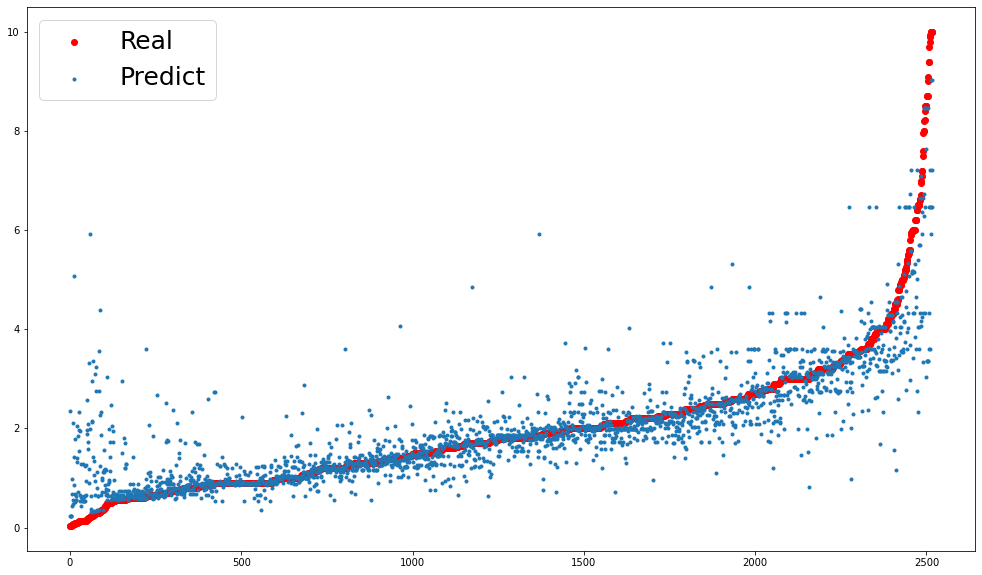

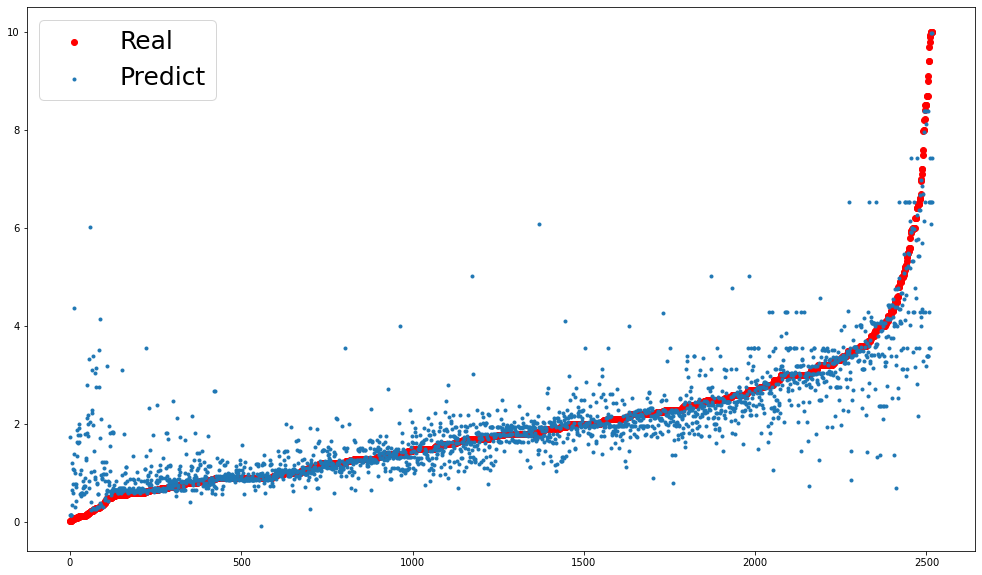

In [29]:
RMSE,MAE,SCORE=runcode(X_train, y_train,X_test,data,y_test)
RMSE1,MAE1,SCORE1=runcode2(X_train, y_train,X_test,data,y_test)

from prettytable import PrettyTable
 
# Specify the Column Names while initializing the Table
myTable = PrettyTable(["", "RandomForestRegressor()", "XGBRegressor()"])
 
# Add rows
myTable.add_row(["RMSE", RMSE, RMSE1])
myTable.add_row(["MAE", MAE, MAE1])
myTable.add_row(["SCORE",SCORE, SCORE1])
print(myTable)
